# No Noise

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def generate_data(n_samples=1000):
    np.random.seed(42)
    X1 = np.random.multivariate_normal([2, 2], [[0.5, 0], [0, 0.5]], size=n_samples // 2)
    X2 = np.random.multivariate_normal([-2, -2], [[0.5, 0], [0, 0.5]], size=n_samples // 2)

    # Labels for each cluster
    y1 = np.ones(n_samples // 2)
    y2 = -np.ones(n_samples // 2)

    # Combine the data
    X = np.vstack([X1, X2])
    y = np.hstack([y1, y2])
    return X, y

# Create an augmented dataset that includes both (x_i, y_i) and (x_i, -y_i)
def augment_dataset(X, y):
    X_augmented = np.vstack([X, X])
    y_augmented = np.hstack([y, -y])
    return X_augmented, y_augmented

def train_classifier(X, y, model_type="Logistic"):
    if model_type == "Logistic":
        model = LogisticRegression(max_iter=1000)
    elif model_type == "DecisionTree":
        model = DecisionTreeClassifier()
    elif model_type == "SVM":
        model = SVC(kernel='rbf', gamma='scale')
    elif model_type == "NeuralNetwork":
        model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000, random_state=42)
    else:
        raise ValueError("Invalid model type. Choose 'Logistic', 'DecisionTree', 'SVM', or 'NeuralNetwork'.")
    model.fit(X, y)
    return model

def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classifier Accuracy: {accuracy:.4f}")

def main():
    X, y = generate_data()

    # Augment the dataset with both (x_i, y_i) and (x_i, -y_i)
    X_augmented, y_augmented = augment_dataset(X, y)

    
    X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

    classifiers = ["Logistic", "DecisionTree", "SVM", "NeuralNetwork"]

    for classifier in classifiers:
        print(f"\nUsing {classifier}:")
        model = train_classifier(X_train, y_train, model_type=classifier)
        evaluate_classifier(model, X_test, y_test)

if __name__ == "__main__":
    main()



Using Logistic:
Classifier Accuracy: 0.4450

Using DecisionTree:
Classifier Accuracy: 0.0875

Using SVM:
Classifier Accuracy: 0.4525

Using NeuralNetwork:
Classifier Accuracy: 0.4350


# Contrastive Loss

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def generate_data(n_samples=1000):
    np.random.seed(42)
    X = np.random.randn(n_samples, 2)
    y = np.random.choice([-1, 1], size=n_samples)
    return X, y

# Contrastive Loss Function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = (1 - label) * torch.pow(euclidean_distance, 2) + \
               label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.fc(x)

# Training with Contrastive Loss
def train_contrastive(X_train, y_train, epochs=100):
    model = SimpleNN()
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Create pairs of (X, y) and (X, -y)
        outputs_y = model(X_tensor)
        outputs_neg_y = model(X_tensor)
        labels = (y_tensor == 1).float()

        loss = criterion(outputs_y, outputs_neg_y, labels)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model

# Testing the Model
def test_model(model, X_test, y_test):
    model.eval()
    X_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_tensor = torch.tensor(y_test, dtype=torch.float32)

    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = torch.argmax(outputs, dim=1).float()

        # Convert predictions to match y_test format {-1, 1}
        predictions = 2 * predictions - 1

        # Calculate accuracy
        accuracy = accuracy_score(y_test, predictions)
        print(f"Test Accuracy: {accuracy:.4f}")

        # Calculate loss
        criterion = ContrastiveLoss()
        outputs_y = model(X_tensor)
        outputs_neg_y = model(X_tensor)
        labels = (y_tensor == 1).float()
        loss = criterion(outputs_y, outputs_neg_y, labels)
        print(f"Test Loss: {loss.item():.4f}")

def main():
   
    X, y = generate_data()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model with contrastive loss
    model = train_contrastive(X_train, y_train)
    
    test_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Epoch 0, Loss: 0.4887486398220062
Epoch 10, Loss: 0.4887486398220062
Epoch 20, Loss: 0.4887486398220062
Epoch 30, Loss: 0.4887486398220062
Epoch 40, Loss: 0.4887486398220062
Epoch 50, Loss: 0.4887486398220062
Epoch 60, Loss: 0.4887486398220062
Epoch 70, Loss: 0.4887486398220062
Epoch 80, Loss: 0.4887486398220062
Epoch 90, Loss: 0.4887486398220062
Test Accuracy: 0.5250
Test Loss: 0.4950


# Two different noises applied to task 1 and task 2 using normal distributions

Evaluating Logistic Regression without noise in test data:

Logistic Regression - Train Accuracy: 0.9919, Test Accuracy: 0.9900
Logistic Regression - Confusion Matrix:
[[191   1]
 [  3 205]]
Logistic Regression - Classification Report:
                     precision    recall  f1-score   support

Negative Class (-1)       0.98      0.99      0.99       192
 Positive Class (1)       1.00      0.99      0.99       208

           accuracy                           0.99       400
          macro avg       0.99      0.99      0.99       400
       weighted avg       0.99      0.99      0.99       400


Evaluating Logistic Regression with noise added to Task-1 in test data:

Logistic Regression - Train Accuracy: 0.9919, Test Accuracy: 0.9850
Logistic Regression - Confusion Matrix:
[[191   1]
 [  5 203]]
Logistic Regression - Classification Report:
                     precision    recall  f1-score   support

Negative Class (-1)       0.97      0.99      0.98       192
 Positive Class (1)   

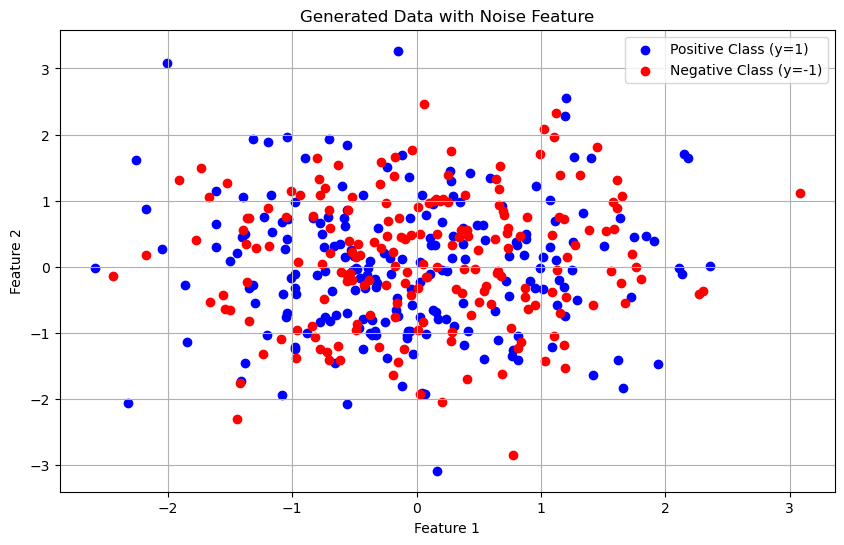

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Data Generation with Noise Feature
def generate_data_with_noise(n_samples=1000):
    np.random.seed(42)
    X = np.random.randn(n_samples, 2)
    y = np.random.choice([-1, 1], size=n_samples)

    # Introduce a noise feature with different distributions for Task 1 and Task 2
    noise_task1 = np.random.normal(0, 0.1, size=n_samples)
    noise_task2 = np.random.normal(0.5, 0.1, size=n_samples)

    # Select noise based on the label
    noise = np.where(y == 1, noise_task1, noise_task2)

    # Add the noise as a third feature
    X = np.column_stack((X, noise))

    return X, y

# Function to add noise specifically to Task-1 data
def add_noise_to_task1(X, y, noise_level=0.1):
    noise = np.random.normal(0, noise_level, size=X.shape)
    # Create a mask for Task-1 (y == 1)
    mask = (y == 1).reshape(-1, 1)
    # Add noise only to rows where the label is 1
    X_noisy = X + mask * noise
    return X_noisy

# Plot the data to visualize the noise effect
def plot_data(X, y):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Positive Class (y=1)')
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Negative Class (y=-1)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Generated Data with Noise Feature')
    plt.legend()
    plt.grid()
    plt.show()

# Function to train and evaluate a model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the training and test sets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"\n{model_name} - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Confusion Matrix for test data
    cm = confusion_matrix(y_test, y_pred_test)
    print(f"{model_name} - Confusion Matrix:\n{cm}")

    # Classification Report for test data
    report = classification_report(y_test, y_pred_test, target_names=["Negative Class (-1)", "Positive Class (1)"])
    print(f"{model_name} - Classification Report:\n{report}")

# Main function to evaluate multiple classifiers
def main():
    # Generate the data
    X, y = generate_data_with_noise(n_samples=2000)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Add noise specifically to Task-1 data in the test set
    X_test_noisy = add_noise_to_task1(X_test, y_test, noise_level=0.1)

    # Initialize classifiers
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "SVM (RBF Kernel)": SVC(kernel='rbf', gamma='scale'),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000, random_state=42)
    }

    # Evaluate each classifier
    for model_name, model in classifiers.items():
        print(f"Evaluating {model_name} without noise in test data:")
        train_and_evaluate_model(X_train, y_train, X_test, y_test, model, model_name)

        print(f"\nEvaluating {model_name} with noise added to Task-1 in test data:")
        train_and_evaluate_model(X_train, y_train, X_test_noisy, y_test, model, model_name)

    # Plot the data
    plot_data(X_test_noisy, y_test)

if __name__ == "__main__":
    main()


# Adding a small amount of noise to task 1

In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data Generation
def generate_data(n_samples=1000):
    np.random.seed(42)
    X = np.random.randn(n_samples, 2)  # Random 2D features
    y = np.random.choice([-1, 1], size=n_samples)  # Random labels {-1, 1}
    return X, y

# Augment the dataset with both (x_i, y_i) and (x_i, -y_i), and add noise to Task-1 (y_i)
def augment_dataset(X, y, add_noise=False, noise_level=0.1):
    if add_noise:
        # Add noise only to Task-1 samples (where y == 1)
        noise = np.random.normal(0, noise_level, size=X.shape)
        X_noisy = np.where(y[:, None] == 1, X + noise, X)  # Apply noise only to positive labels
        X_augmented = np.vstack([X_noisy, X])
    else:
        X_augmented = np.vstack([X, X])

    y_augmented = np.hstack([y, -y])
    return X_augmented, y_augmented

# Train and Evaluate Model
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type="Logistic"):
    if model_type == "Logistic":
        model = LogisticRegression(max_iter=1000)
    elif model_type == "DecisionTree":
        model = DecisionTreeClassifier()
    elif model_type == "SVM":
        model = SVC(kernel='rbf', gamma='scale')
    elif model_type == "NeuralNetwork":
        model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    return train_accuracy, test_accuracy

# Main function to evaluate models
def main():
    X, y = generate_data(n_samples=2000)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_aug, y_train_aug = augment_dataset(X_train, y_train)
    X_test_aug, y_test_aug = augment_dataset(X_test, y_test)

    print("Evaluating models without noise...")

    # Logistic Regression
    lin_train_acc, lin_test_acc = train_and_evaluate(X_train_aug, y_train_aug, X_test_aug, y_test_aug, model_type="Logistic")
    print(f"Logistic Regression - Train Accuracy: {lin_train_acc:.4f}, Test Accuracy: {lin_test_acc:.4f}")

    # Decision Tree
    dt_train_acc, dt_test_acc = train_and_evaluate(X_train_aug, y_train_aug, X_test_aug, y_test_aug, model_type="DecisionTree")
    print(f"Decision Tree - Train Accuracy: {dt_train_acc:.4f}, Test Accuracy: {dt_test_acc:.4f}")

    # SVM
    svm_train_acc, svm_test_acc = train_and_evaluate(X_train_aug, y_train_aug, X_test_aug, y_test_aug, model_type="SVM")
    print(f"SVM - Train Accuracy: {svm_train_acc:.4f}, Test Accuracy: {svm_test_acc:.4f}")

    # Neural Network
    nn_train_acc, nn_test_acc = train_and_evaluate(X_train_aug, y_train_aug, X_test_aug, y_test_aug, model_type="NeuralNetwork")
    print(f"Neural Network - Train Accuracy: {nn_train_acc:.4f}, Test Accuracy: {nn_test_acc:.4f}")

    print("\nEvaluating models with noise added only to Task-1 data...")

    # Augment the dataset with noise only for Task-1 (y_i == 1)
    X_train_noisy, y_train_noisy = augment_dataset(X_train, y_train, add_noise=True, noise_level=0.1)
    X_test_noisy, y_test_noisy = augment_dataset(X_test, y_test, add_noise=True, noise_level=0.1)

    # Logistic Regression
    lin_train_acc, lin_test_acc = train_and_evaluate(X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy, model_type="Logistic")
    print(f"Logistic Regression with Noise - Train Accuracy: {lin_train_acc:.4f}, Test Accuracy: {lin_test_acc:.4f}")

    # Decision Tree
    dt_train_acc, dt_test_acc = train_and_evaluate(X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy, model_type="DecisionTree")
    print(f"Decision Tree with Noise - Train Accuracy: {dt_train_acc:.4f}, Test Accuracy: {dt_test_acc:.4f}")

    # SVM
    svm_train_acc, svm_test_acc = train_and_evaluate(X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy, model_type="SVM")
    print(f"SVM with Noise - Train Accuracy: {svm_train_acc:.4f}, Test Accuracy: {svm_test_acc:.4f}")

    # Neural Network
    nn_train_acc, nn_test_acc = train_and_evaluate(X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy, model_type="NeuralNetwork")
    print(f"Neural Network with Noise - Train Accuracy: {nn_train_acc:.4f}, Test Accuracy: {nn_test_acc:.4f}")

if __name__ == "__main__":
    main()


Evaluating models without noise...
Logistic Regression - Train Accuracy: 0.5000, Test Accuracy: 0.5000
Decision Tree - Train Accuracy: 0.5000, Test Accuracy: 0.5000
SVM - Train Accuracy: 0.5000, Test Accuracy: 0.5000
Neural Network - Train Accuracy: 0.5000, Test Accuracy: 0.5000

Evaluating models with noise added only to Task-1 data...
Logistic Regression with Noise - Train Accuracy: 0.5028, Test Accuracy: 0.4975
Decision Tree with Noise - Train Accuracy: 0.7478, Test Accuracy: 0.5038
SVM with Noise - Train Accuracy: 0.5041, Test Accuracy: 0.4975
Neural Network with Noise - Train Accuracy: 0.5062, Test Accuracy: 0.5025
